In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

# Importing DES mask with nside=64

/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


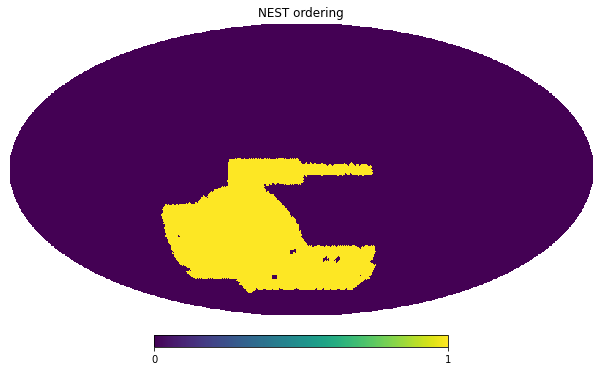

In [2]:
mask = hp.read_map('DESY3_sky_mask.fits') # It's in RING ordering


nside = 64
npix = hp.nside2npix(nside=nside)


#Create boolean mask with nside
mask64 = np.ceil(hp.ud_grade(mask,nside))

#Changing order of mask to NEST
mask64 = hp.reorder(mask64,r2n=True)

hp.mollview(mask64,title='NEST ordering',nest=True)

# Creating Data

In [3]:
def power_spectrum(l, A, mu, sigma):
    """Generate power spectrum from gaussian distribution.
    Input:
    l      angular location
    A      amplitude
    simga  standard deviation
    mu     mean
    """
    return A*np.exp((-1/2)*(l-mu)**2/(sigma**2))


batch_size = 5
learning_rate = 3e-4

indices = np.arange(hp.nside2npix(nside)) # indices of relevant pixels [0, pixels)
l = np.arange(nside)

c_l = power_spectrum(l, 1, 5,25)

n=2 # number of datasets


gaussian_maps = np.array([hp.reorder(hp.synfast(c_l, nside),inp='RING',out='NESTED') for i in range(n)])
#rescale - ensure all values are between 0-1 with average on 0.5.
factor = 20*np.max(np.abs(gaussian_maps))*np.ones(shape=gaussian_maps.shape)
mean = 0.5 #because of last layer having softmax activation, model can't replicate -ve values.
gaussian_maps  = gaussian_maps/factor+mean*np.ones(shape=gaussian_maps.shape)        
print(gaussian_maps.shape)

(2, 49152)


/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


# Integrating Mask and Data

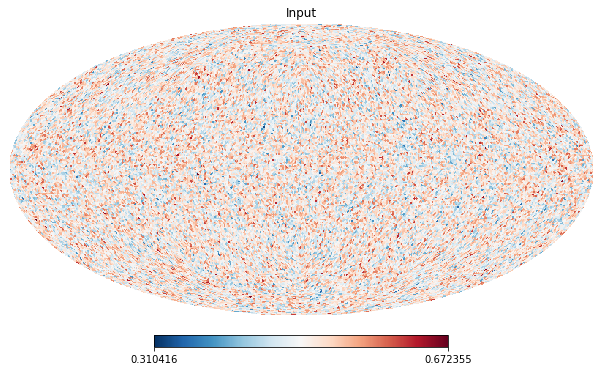

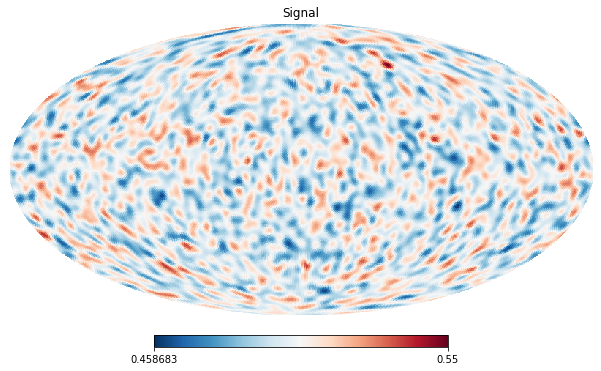

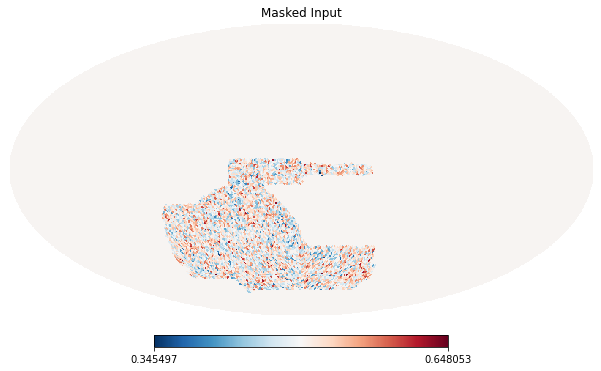

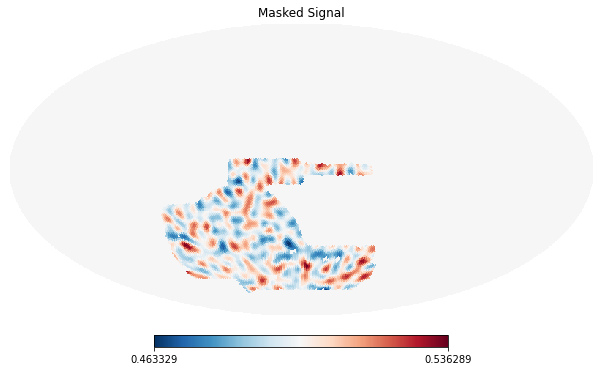

In [4]:
R = gaussian_maps
N = gaussian_maps + np.random.normal(0,0.04,gaussian_maps.shape)
hp.mollview(N[0], title='Input', nest=True, cmap=plt.cm.RdBu_r)
hp.mollview(R[0], title='Signal', nest=True, cmap=plt.cm.RdBu_r)

# With mask
mask_R = np.array([np.where(mask64>0.5,R_i,mean) for R_i in R])
mask_N = np.array([np.where(mask64>0.5,N_i,mean) for N_i in N])

hp.mollview(mask_N[0], title='Masked Input', nest=True, cmap=plt.cm.RdBu_r)
hp.mollview(mask_R[0], title='Masked Signal', nest=True, cmap=plt.cm.RdBu_r)

# You can lower the noise of N to near zero to clearly see everything is working.

# Rotating Data

/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/home/david/anaconda3/envs/deepmass_gpu/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


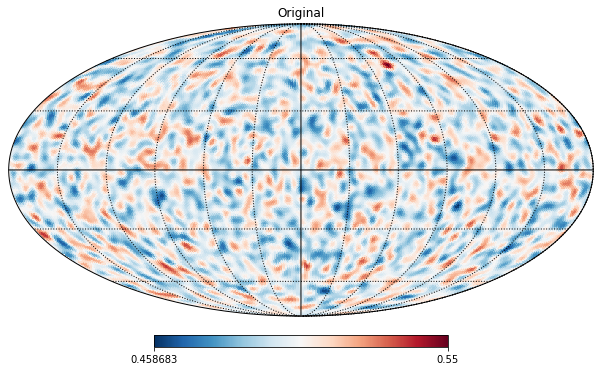

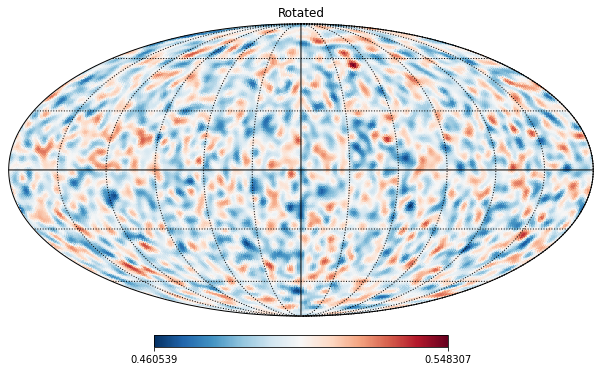

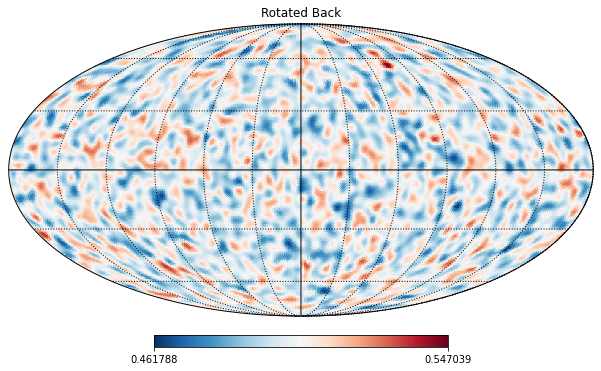

In [5]:
def rotate(sky,z,y,x,nside,p=3,pixel=True,forward=True,nest2ring=True):
    '''    
    Up-samples the data, rotates map, then pools it to original nside. Map has to be in "NEST" ordering.
    
    Input:
    sky        map (In NEST ordering if nest2ring=True)
    z          longitude
    y          latitude
    x          3rd degree of freedom to include rotations
    nside
    p          data is up-sampled by 2**p 
    pixel      if True rotation happens in pixel space. Otherwise it happens in spherical harmonics space.
    forward    if True, +10degree rotation does +10degree rotation. Otherwise it does a -10 degree rotation.
    nest2ring  if True converts NEST ordering to RING ordering before rotating, and RING to NEST after rotation
               (this is because Rotator object only works with RING ordering).
    
    Output:
    Rotated map in NEST ordering.
    '''
    #the point provided in rot will be the center of the map
    rot_custom = hp.Rotator(rot=[z,y,x],inv=forward)#deg=True
    
    if nest2ring == True:
        sky = hp.reorder(sky,n2r=True)
    
    up = hp.ud_grade(sky,nside*2**p)#up-sample
    if pixel == True:
        m_smoothed_rotated_pixel = rot_custom.rotate_map_pixel(up)
    else:
        m_smoothed_rotated_pixel = rot_custom.rotate_map_alms(up)#uses spherical harmonics instad
    down = hp.ud_grade(m_smoothed_rotated_pixel,nside)#down-sample
    
    if nest2ring == True:
        down = hp.reorder(down,r2n=True)
    
    return down
    

ang1 = 30
ang2 = 0
ang3 = 0

R = np.array([rotate(i,ang1,ang2,ang3,nside) for i in gaussian_maps])

hp.mollview(gaussian_maps[0], title='Original', nest=True, cmap=plt.cm.RdBu_r)
hp.graticule()
hp.mollview(R[0], title='Rotated', nest=True, cmap=plt.cm.RdBu_r)
hp.graticule()

R = np.array([rotate(i,ang1,ang2,ang3,nside,forward=False) for i in R])

hp.mollview(R[0], title='Rotated Back', nest=True, cmap=plt.cm.RdBu_r)
hp.graticule()